In [49]:
## import packages
import torch
import random
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import os
import numpy.testing as npt
#from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Checks for the availability of GPU 
is_cuda = torch.cuda.is_available()
# is_cuda = False
if is_cuda:
    print("working on gpu!")
else:
    print("No gpu! only cpu ;)")
    

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = '0'

############################################################################### 

working on gpu!


In [50]:
import torchvision
import torchvision.transforms as transforms
import os

root = './data/'
if not os.path.isdir(root):
    os.mkdir(root)

train_bs = 128

# Data transformation for the DataLoader - normalizes to between [-1,1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

training_data = torchvision.datasets.MNIST(root, train=True, transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=train_bs, shuffle=True, drop_last=True)

In [51]:
def noise(bs, dim):

    
    out = (torch.randn((bs, dim)))
    if is_cuda:
        out = out.cuda()
    return out

In [52]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_size=784):
        super(Generator, self).__init__()
        
        '''
        REST OF THE MODEL HERE
        
        # define a fully connected layer (self.layer1) from noise_dim -> 256 neurons      
        # define a leaky relu layer(self.leaky_relu) with negative slope=0.2. We can reuse the same layer multiple times.
        # define a fully connected layer (self.layer2) from 256 -> 512 neurons
        # define a fully connected layer (self.layer3) from 512 -> 1024 neurons
        # define a fully connected layer (self.layer4) from 1024 -> out_size neurons
        # define a tanh activation function (self.tanh)
        
        '''
        # your code here
        
        # define a fully connected layer (self.layer1) from noise_dim -> 256 neurons 
        self.Layer1 = nn.Linear(noise_dim, 256)
        # define a leaky relu layer(self.leaky_relu) with negative slope=0.2. We can reuse the same layer multiple times.
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        # define a fully connected layer (self.layer2) from 256 -> 512 neurons
        self.Layer2 = nn.Linear(256,512)
        # define a fully connected layer (self.layer3) from 512 -> 1024 neurons
        self.Layer3 = nn.Linear(512, 1024)
        # define a fully connected layer (self.layer4) from 1024 -> out_size neurons
        self.Layer4 = nn.Linear(1024, out_size)
        # define a tanh activation function (self.tanh)
        self.tanh = nn.Tanh()        
        
        
        
    def forward(self, x):
        '''
        Make a forward pass of the input through the generator. Leaky relu is used as the activation 
        function in all the intermediate layers. Tanh activation function is only used at the end (which
        is after self.layer4)
        
        Note that, generator takes an random noise as input and gives out fake "images". Hence, the Tensor 
        output after tanh activation function should be reshaped into the same size as the real images. i.e., 
        [batch_size, n_channels, H, W] == (batch_size, 1,28,28). You may use the .view(.) function to acheive it.
         
        '''
        # your code here
        
        x = self.Layer1(x)
        x = self.leaky_relu(x)
        x = self.Layer2(x)
        x = self.leaky_relu(x)
        x = self.Layer3(x)
        x = self.leaky_relu(x)
        x = self.Layer4(x)
        x = self.leaky_relu(x)
        x = self.tanh(x)
        #x = nn.Unflatten(x, (x.shape[0],1,28,28))
        x = torch.reshape(x, [x.shape[0], 1, 28, 28])
        
        
        return x

In [53]:
# Initialize the Generator and move it to GPU (if is_cuda)
generator = Generator()
print(generator)
# If you have a system with a GPU, you may want to install torchsummary and display the network in more detail 
# summary(generator,(100,), device='cpu')

# move to GPU
if is_cuda:
    generator = generator.cuda()

Generator(
  (Layer1): Linear(in_features=100, out_features=256, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (Layer2): Linear(in_features=256, out_features=512, bias=True)
  (Layer3): Linear(in_features=512, out_features=1024, bias=True)
  (Layer4): Linear(in_features=1024, out_features=784, bias=True)
  (tanh): Tanh()
)


In [54]:


a = torch.ones(5,100)
if is_cuda:
    a = a.cuda()
out = generator(a)
npt.assert_equal(out.shape, (5,1,28,28))
assert np.max(out.detach().cpu().numpy()) <= 1
assert np.min(out.detach().cpu().numpy()) >= -1


In [55]:


class Discriminator(nn.Module):
    def __init__(self, input_size=784):
        super(Discriminator, self).__init__()

        
        # define a fully connected layer (self.layer1) from input_size -> 512 neurons
        self.Layer1 = nn.Linear(input_size, 512)
        # define a leaky relu layer(self.leaky_relu) with negative slope=0.2. (we will reuse the same layer)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        # define a fully connected layer (self.layer2) from 512 -> 256 neurons
        self.Layer2 = nn.Linear(512, 256)
        # define a fully connected layer (self.layer3) from 256 -> 1 neurons
        self.Layer3 = nn.Linear(256, 1)
        # define a fully connected layer (self.layer3) from 256 -> 1 neurons
        
        
    
    def forward(self, x):

        
        y = torch.reshape(x, [x.shape[0], 784])
        y = self.Layer1(y)
        y = self.leaky_relu(y)
        y = self.Layer2(y)
        y = self.leaky_relu(y)
        y = self.Layer3(y)
        y = self.leaky_relu(y)

        
        
        return y       

In [56]:
# Initialize the Discriminator and move it to GPU (if is_cuda)
discriminator = Discriminator()

print(discriminator)

# move to GPU
if is_cuda:
    discriminator = discriminator.cuda()

Discriminator(
  (Layer1): Linear(in_features=784, out_features=512, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (Layer2): Linear(in_features=512, out_features=256, bias=True)
  (Layer3): Linear(in_features=256, out_features=1, bias=True)
)


In [57]:


a = torch.ones(5,1,28,28)
if is_cuda:
    a = a.cuda()
out = discriminator(a)
npt.assert_equal(out.shape, (5,1))


In [58]:

bce_loss = nn.BCEWithLogitsLoss()

In [59]:
def DLoss(logits_real, logits_fake, targets_real, targets_fake):

    
    # Concatenate the logits_real and the logits_fake using torch.cat() to get 'logits'
    logits = torch.cat((logits_real, logits_fake))
    # Concatenate the targets_real and the targets_fake using torch.cat() to get 'targets'
    targets = torch.cat((targets_real, targets_fake))
    # estimate the loss using the BCEWithLogitsLoss object 'bce' with 'logits' and 'targets'
    loss = bce_loss(logits, targets)
    
    return loss

In [60]:
def GLoss(logits_fake, targets_real):

    
    g_loss = bce_loss(logits_fake, targets_real)
    
    
    return g_loss

In [61]:
#The following settings generated realistic images. Feel free to adjust the settings.
epochs = 80 #orig 40
noise_dim = 100
LR = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
if is_cuda:
    bce_loss.cuda()

Epoch:   0
D Loss:  0.8249351978302002
G Loss:  0.7400273084640503


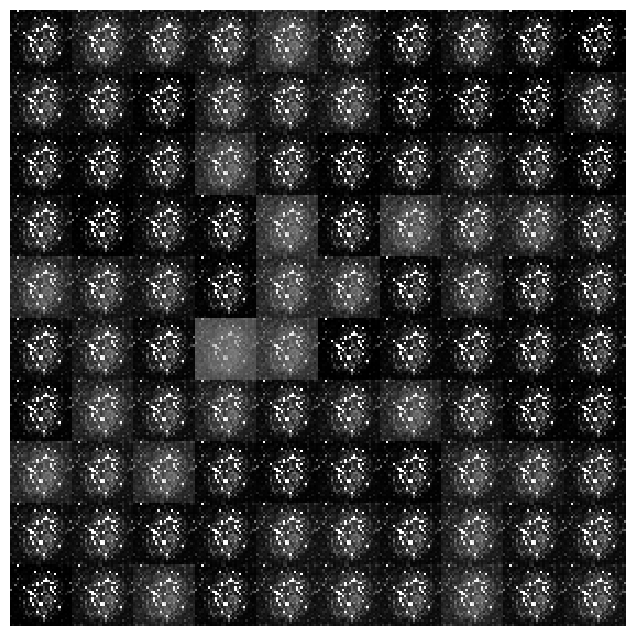

Epoch:   1
D Loss:  0.5792505741119385
G Loss:  0.7132968902587891
Epoch:   2
D Loss:  0.5286906957626343
G Loss:  0.7942253947257996


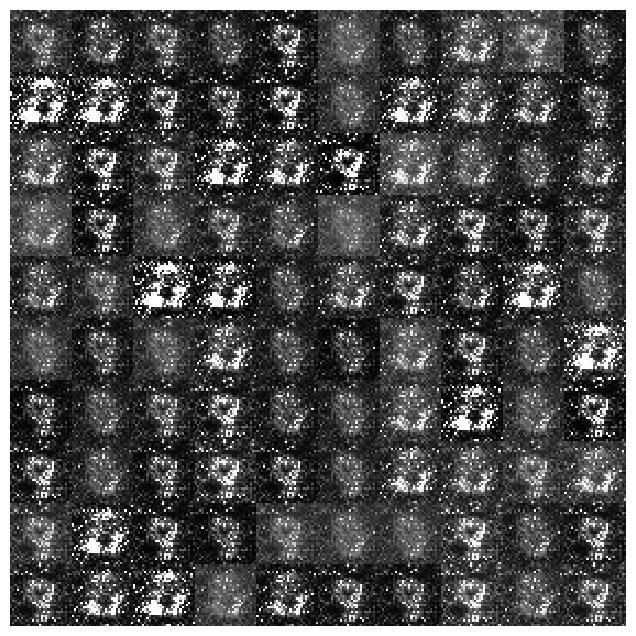

Epoch:   3
D Loss:  0.5160402059555054
G Loss:  0.7440815567970276
Epoch:   4
D Loss:  0.5148797035217285
G Loss:  0.908261775970459


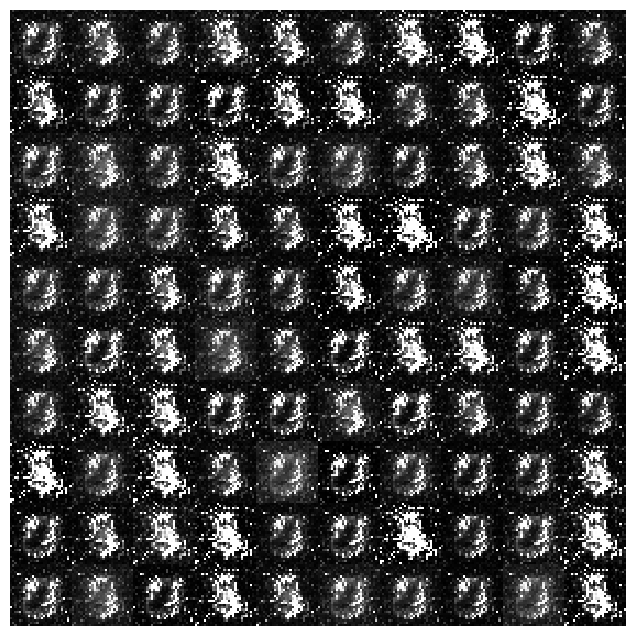

Epoch:   5
D Loss:  0.5682217478752136
G Loss:  2.246116876602173
Epoch:   6
D Loss:  0.4827565550804138
G Loss:  0.9333693981170654


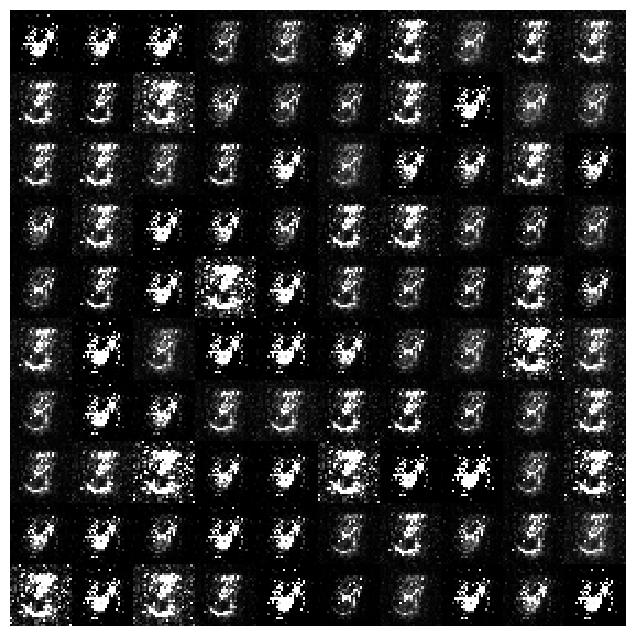

Epoch:   7
D Loss:  0.4673340916633606
G Loss:  1.3192448616027832
Epoch:   8
D Loss:  0.4260747730731964
G Loss:  1.046980619430542


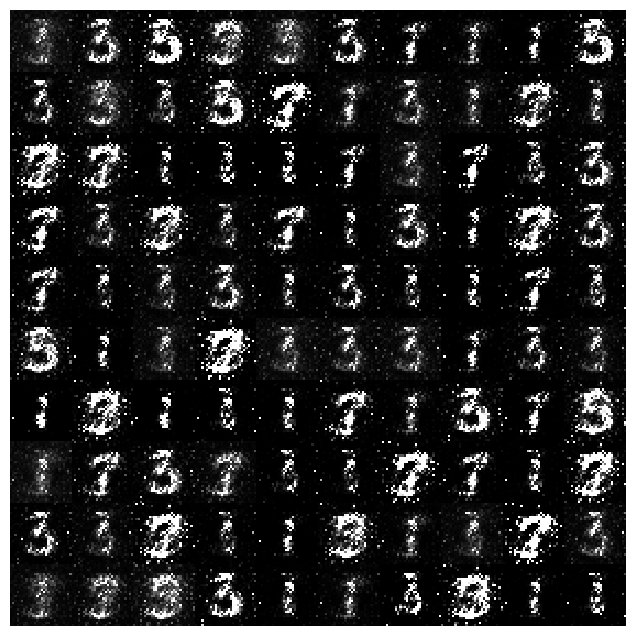

Epoch:   9
D Loss:  0.4556400775909424
G Loss:  1.1132848262786865
Epoch:   10
D Loss:  0.4487383961677551
G Loss:  1.0917224884033203


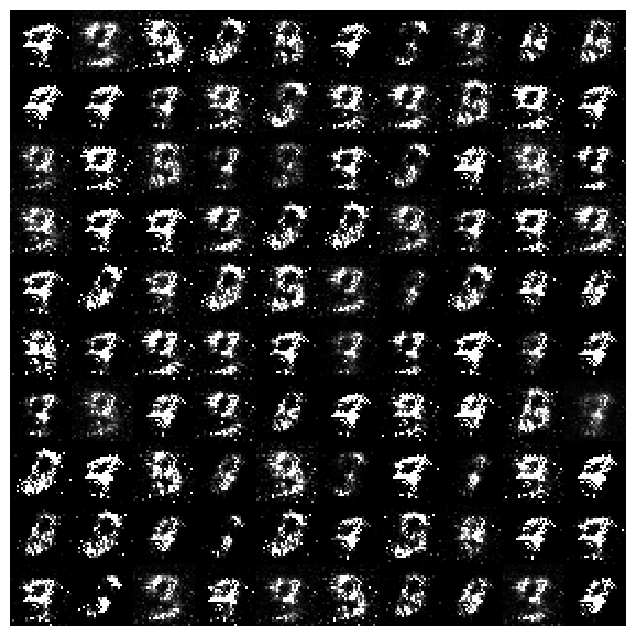

Epoch:   11
D Loss:  0.4088476896286011
G Loss:  1.4245399236679077
Epoch:   12
D Loss:  0.46901994943618774
G Loss:  1.184828758239746


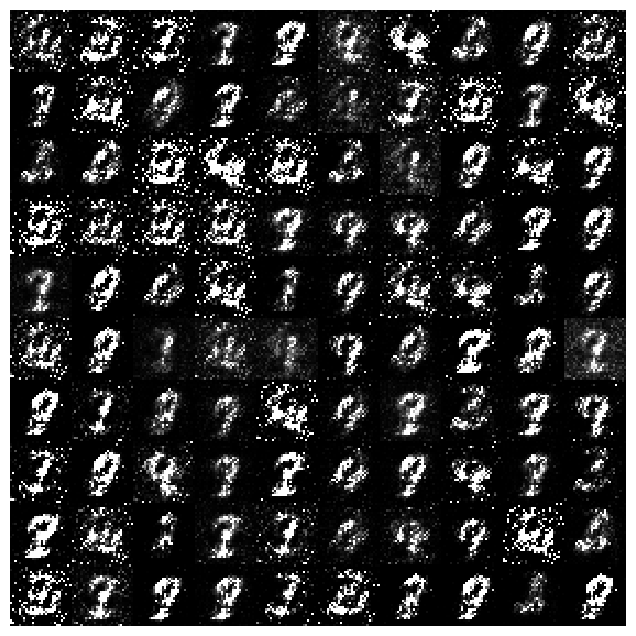

Epoch:   13
D Loss:  0.47822803258895874
G Loss:  1.0791054964065552
Epoch:   14
D Loss:  0.5674515962600708
G Loss:  1.192970633506775


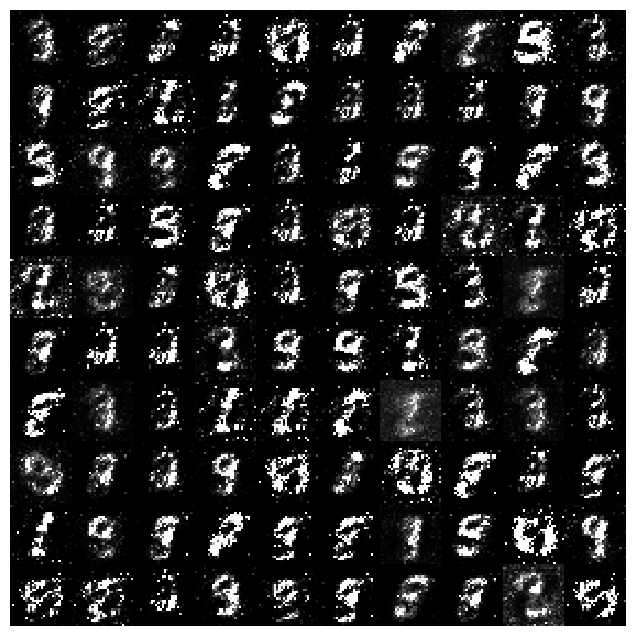

Epoch:   15
D Loss:  0.47530311346054077
G Loss:  1.2743207216262817
Epoch:   16
D Loss:  0.467204749584198
G Loss:  1.0676978826522827


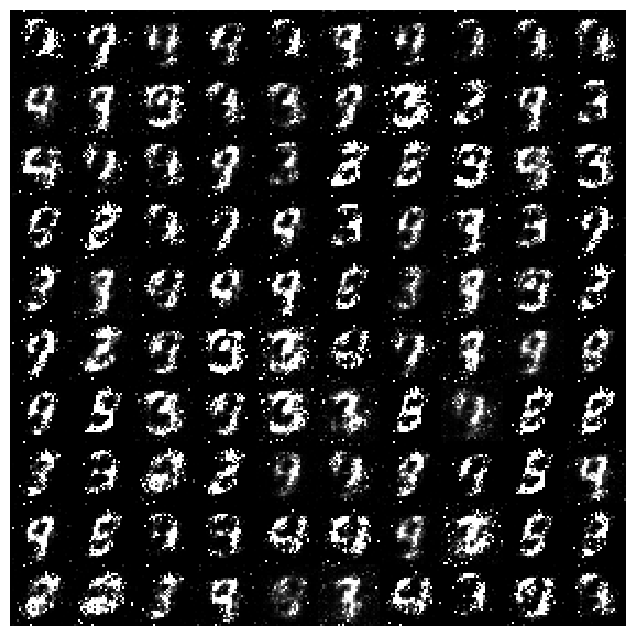

Epoch:   17
D Loss:  0.4746581017971039
G Loss:  1.1941447257995605
Epoch:   18
D Loss:  0.5347617268562317
G Loss:  1.5632940530776978


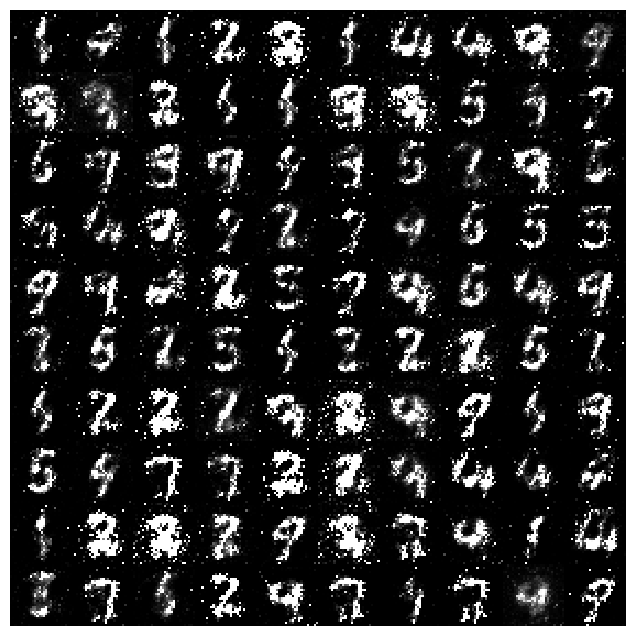

Epoch:   19
D Loss:  0.5814042091369629
G Loss:  1.0008904933929443
Epoch:   20
D Loss:  0.5259448289871216
G Loss:  0.9894782304763794


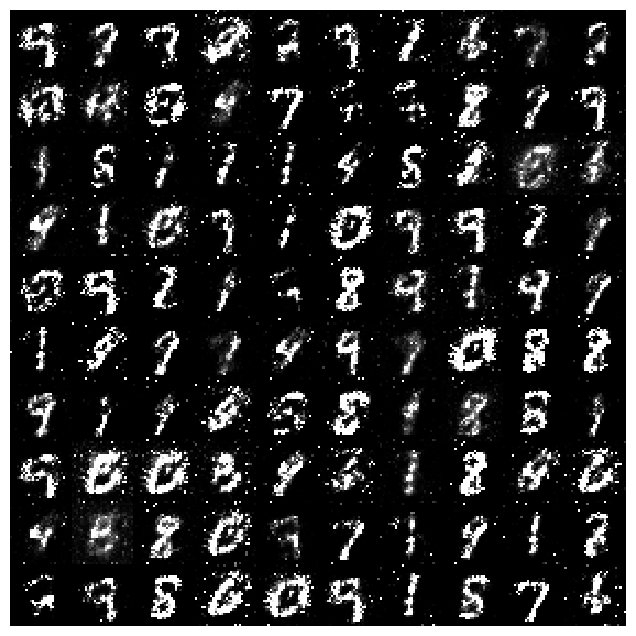

Epoch:   21
D Loss:  0.5215182304382324
G Loss:  0.9378886222839355
Epoch:   22
D Loss:  0.5382912158966064
G Loss:  0.9087671041488647


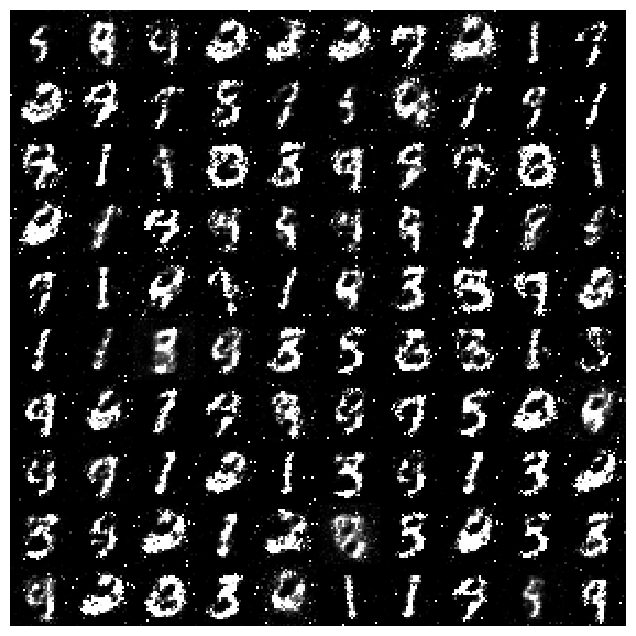

Epoch:   23
D Loss:  0.6118416786193848
G Loss:  0.7653454542160034
Epoch:   24
D Loss:  0.566437840461731
G Loss:  0.9342215061187744


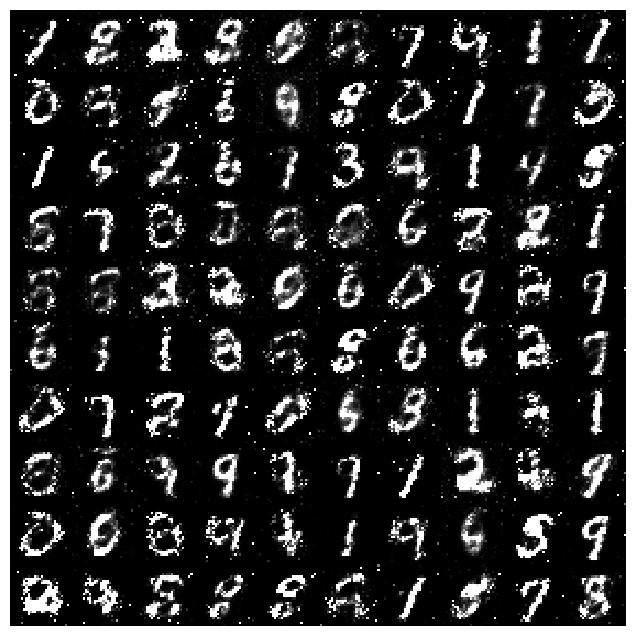

Epoch:   25
D Loss:  0.5925611257553101
G Loss:  1.0802221298217773
Epoch:   26
D Loss:  0.6383819580078125
G Loss:  1.045534372329712


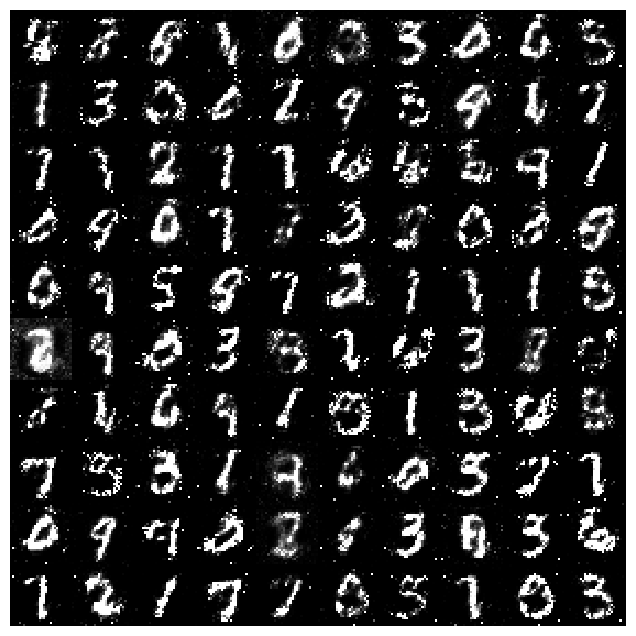

Epoch:   27
D Loss:  0.6006314754486084
G Loss:  0.9263074994087219
Epoch:   28
D Loss:  0.5659997463226318
G Loss:  0.767863929271698


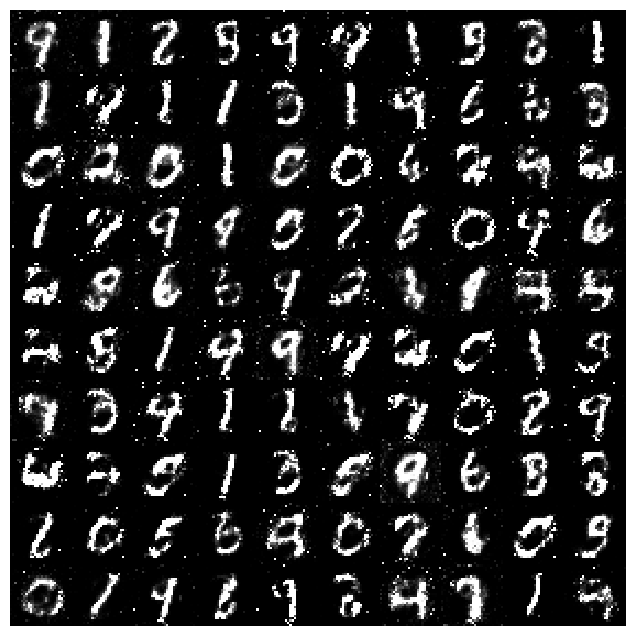

Epoch:   29
D Loss:  0.588194727897644
G Loss:  0.7295189499855042
Epoch:   30
D Loss:  0.5790319442749023
G Loss:  0.8503910303115845


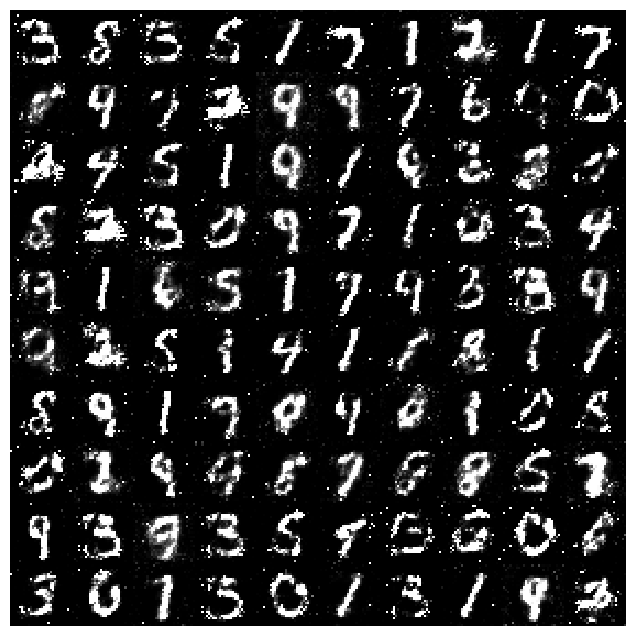

Epoch:   31
D Loss:  0.6458799242973328
G Loss:  1.0521881580352783
Epoch:   32
D Loss:  0.599006175994873
G Loss:  0.7684177160263062


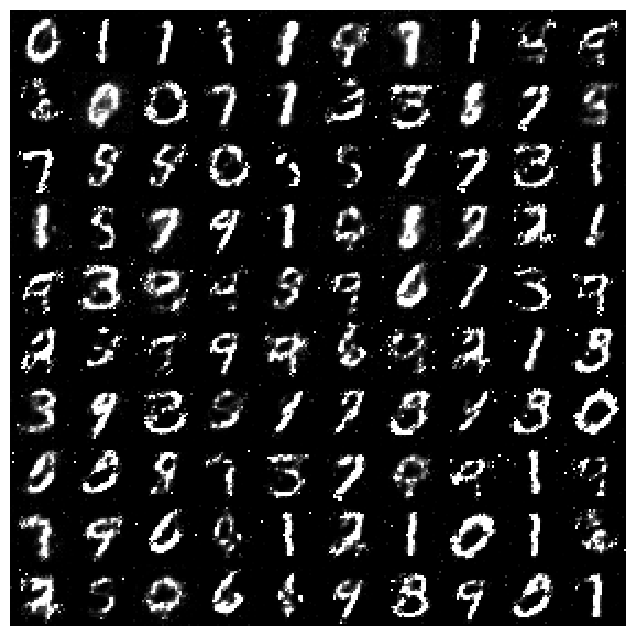

Epoch:   33
D Loss:  0.6071938276290894
G Loss:  0.8343541622161865
Epoch:   34
D Loss:  0.5987717509269714
G Loss:  0.7933247685432434


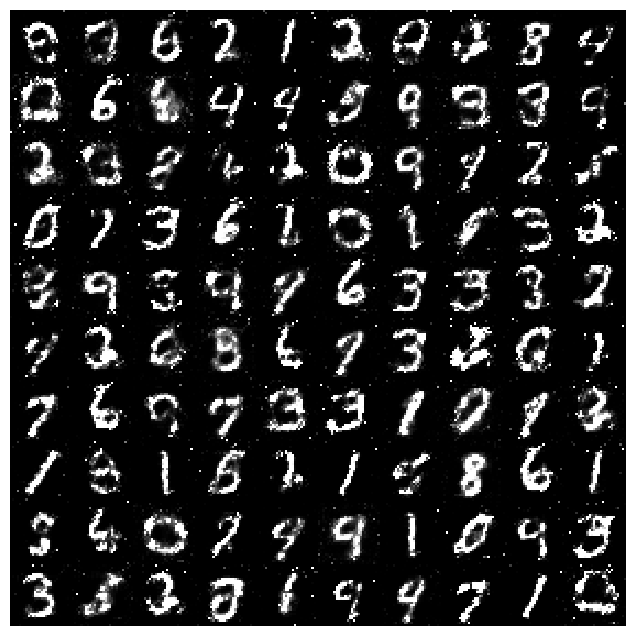

Epoch:   35
D Loss:  0.7426333427429199
G Loss:  1.1920156478881836
Epoch:   36
D Loss:  0.5903586149215698
G Loss:  0.9509652853012085


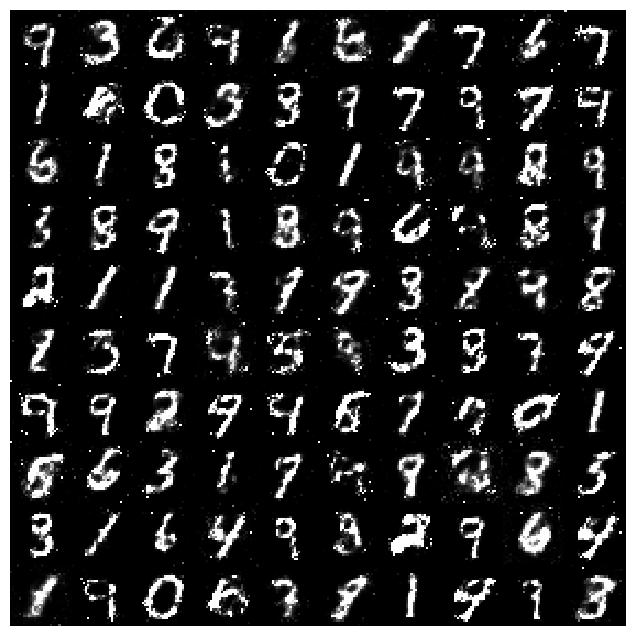

Epoch:   37
D Loss:  0.6138942241668701
G Loss:  0.7671957015991211
Epoch:   38
D Loss:  0.588249683380127
G Loss:  0.7495735287666321


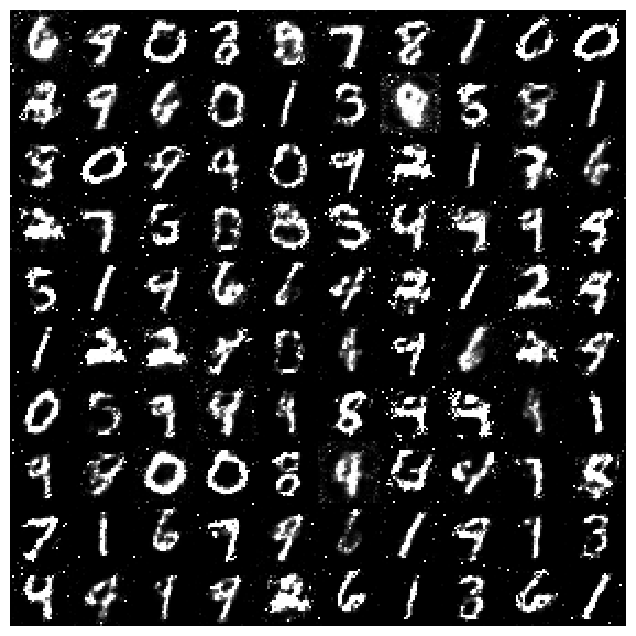

Epoch:   39
D Loss:  0.6002645492553711
G Loss:  0.6398650407791138
Epoch:   40
D Loss:  0.5776233077049255
G Loss:  0.8099864721298218


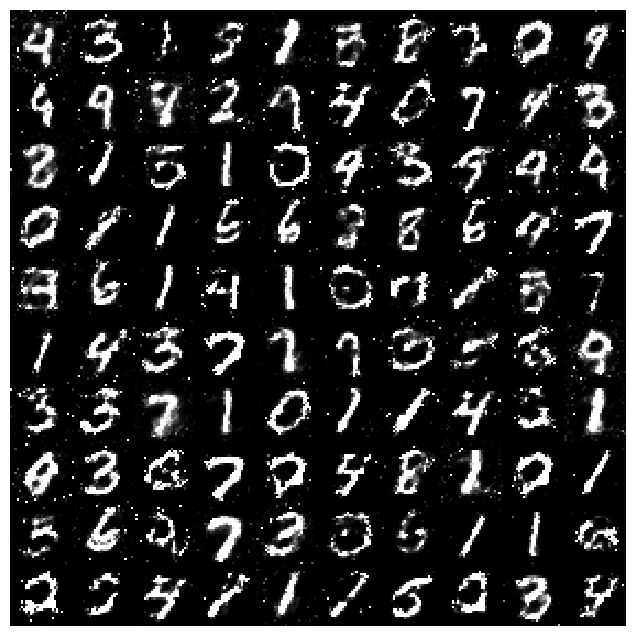

Epoch:   41
D Loss:  0.5791071653366089
G Loss:  0.7937488555908203
Epoch:   42
D Loss:  0.5975806713104248
G Loss:  0.8438736200332642


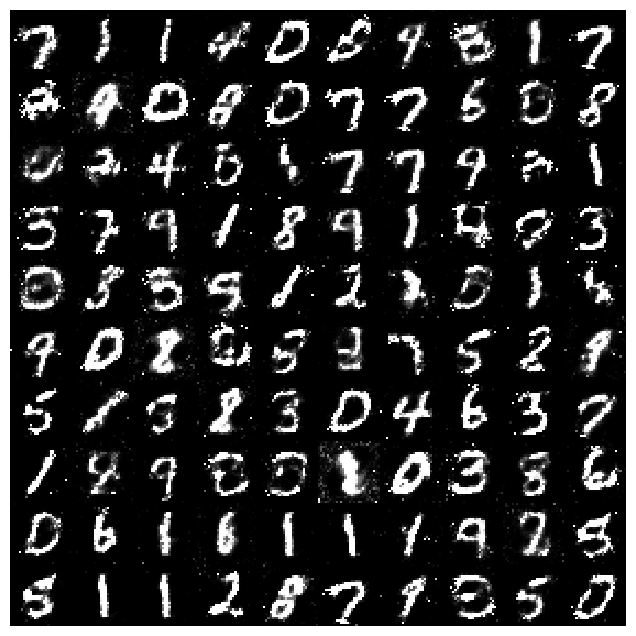

Epoch:   43
D Loss:  0.5915315747261047
G Loss:  0.9482014179229736
Epoch:   44
D Loss:  0.5907586812973022
G Loss:  0.7143363952636719


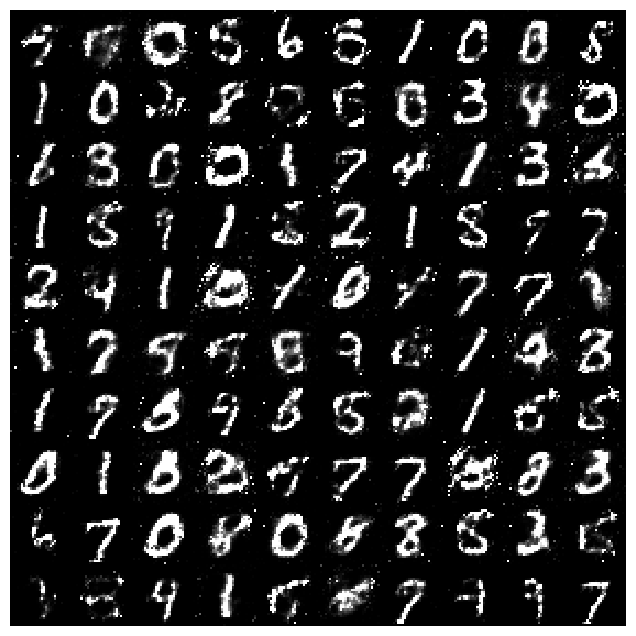

Epoch:   45
D Loss:  0.5678001046180725
G Loss:  0.7783309817314148
Epoch:   46
D Loss:  0.5896903276443481
G Loss:  0.8222166299819946


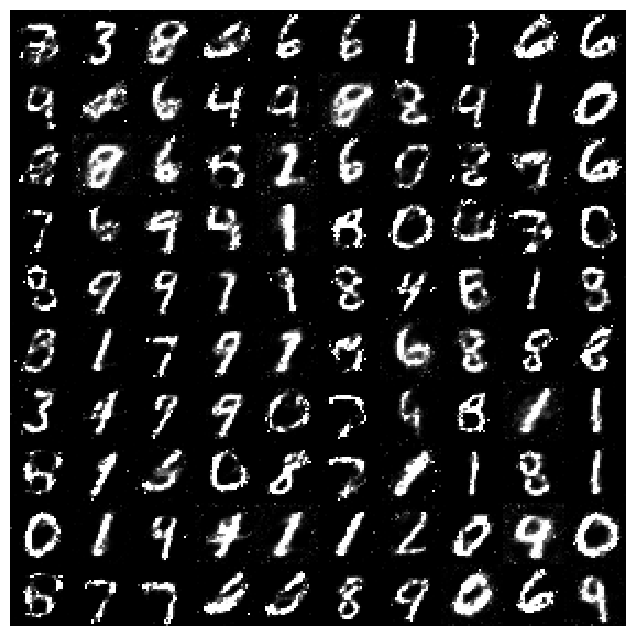

Epoch:   47
D Loss:  0.6625471711158752
G Loss:  0.7910778522491455
Epoch:   48
D Loss:  0.5859611630439758
G Loss:  0.8719516396522522


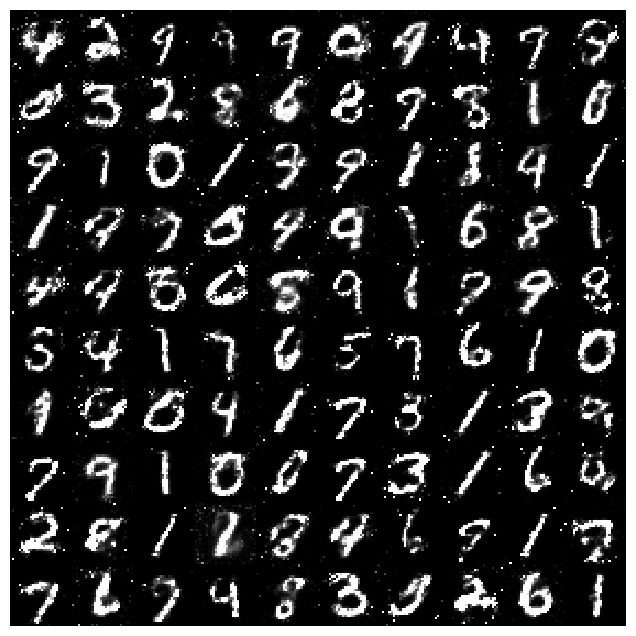

Epoch:   49
D Loss:  0.5954119563102722
G Loss:  1.0237109661102295
Epoch:   50
D Loss:  0.5890315175056458
G Loss:  0.7349361777305603


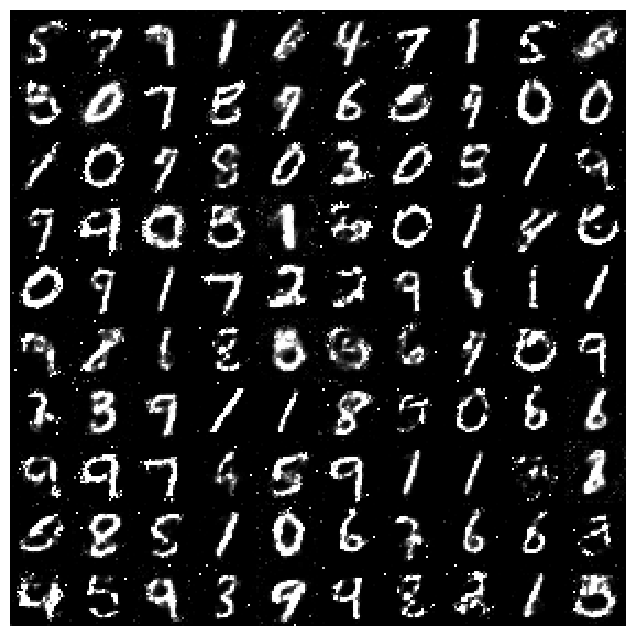

Epoch:   51
D Loss:  0.618186354637146
G Loss:  0.8431349396705627
Epoch:   52
D Loss:  0.6413353681564331
G Loss:  0.8864367008209229


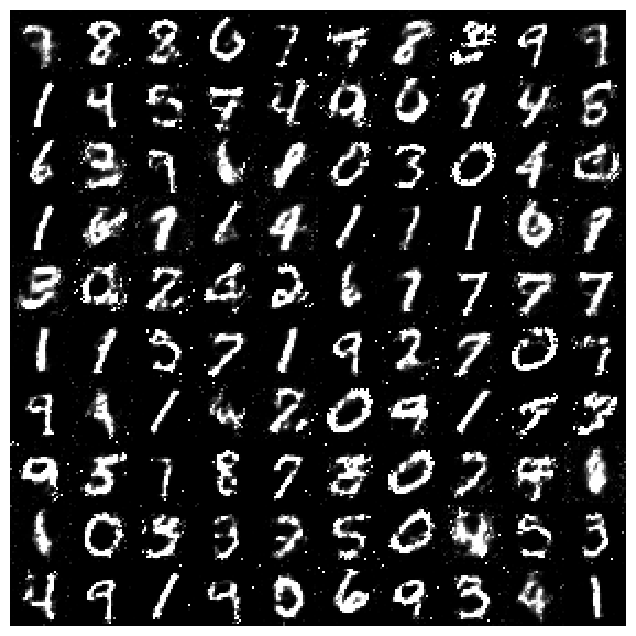

Epoch:   53
D Loss:  0.576204240322113
G Loss:  0.789338231086731
Epoch:   54
D Loss:  0.5776157379150391
G Loss:  0.8450963497161865


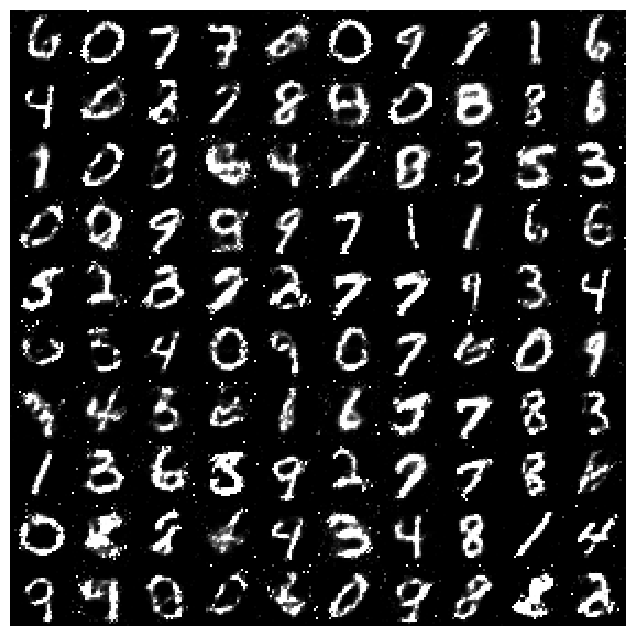

Epoch:   55
D Loss:  0.6627894043922424
G Loss:  0.8334095478057861
Epoch:   56
D Loss:  0.6302664279937744
G Loss:  0.6912683248519897


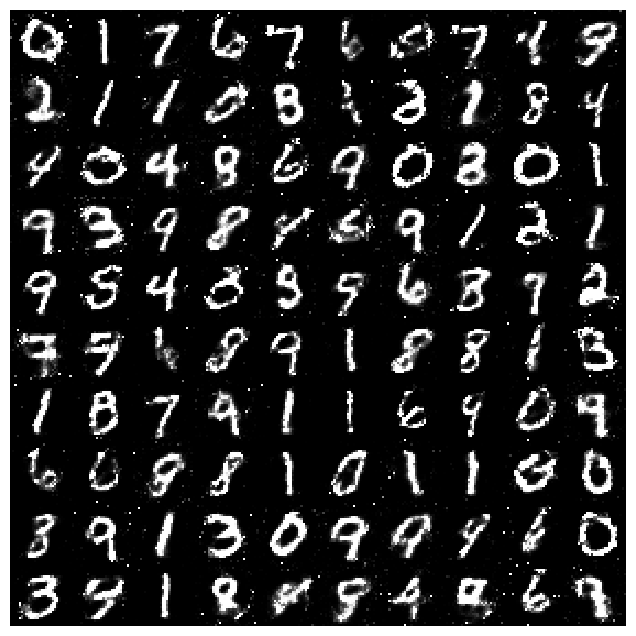

Epoch:   57
D Loss:  0.5686198472976685
G Loss:  0.8096378445625305
Epoch:   58
D Loss:  0.5816361904144287
G Loss:  0.7927898168563843


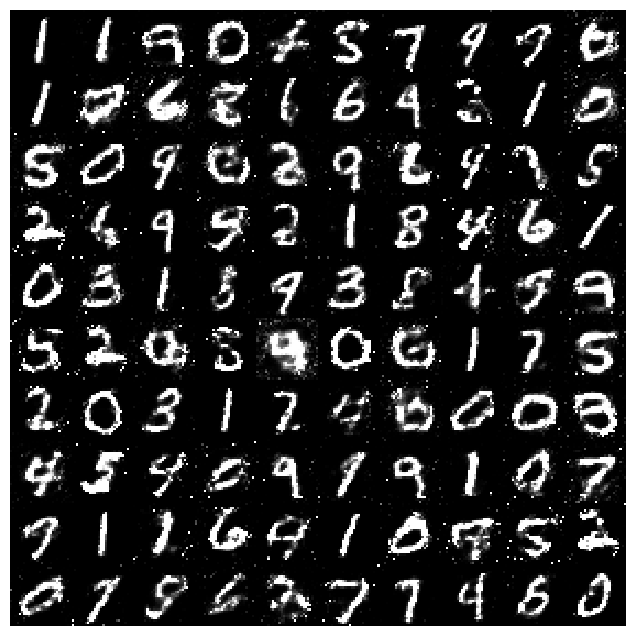

Epoch:   59
D Loss:  0.5883082747459412
G Loss:  1.0092928409576416
Epoch:   60
D Loss:  0.6024359464645386
G Loss:  0.846930980682373


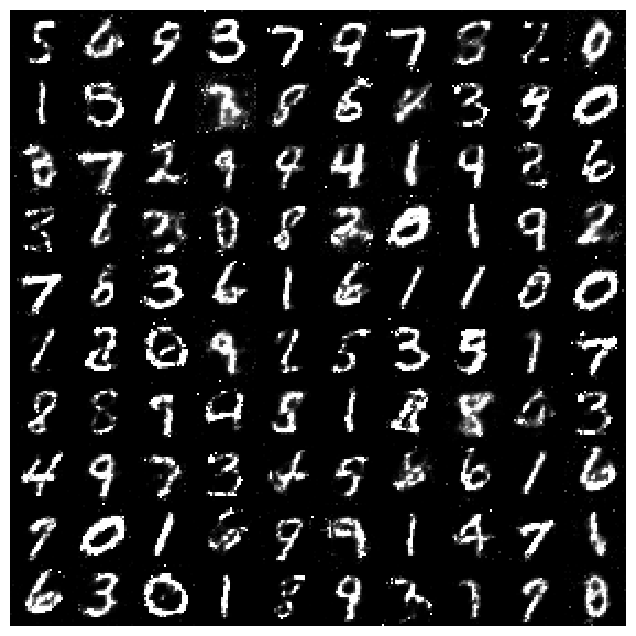

Epoch:   61
D Loss:  0.5818362236022949
G Loss:  0.8332947492599487
Epoch:   62
D Loss:  0.5817877054214478
G Loss:  0.8253782987594604


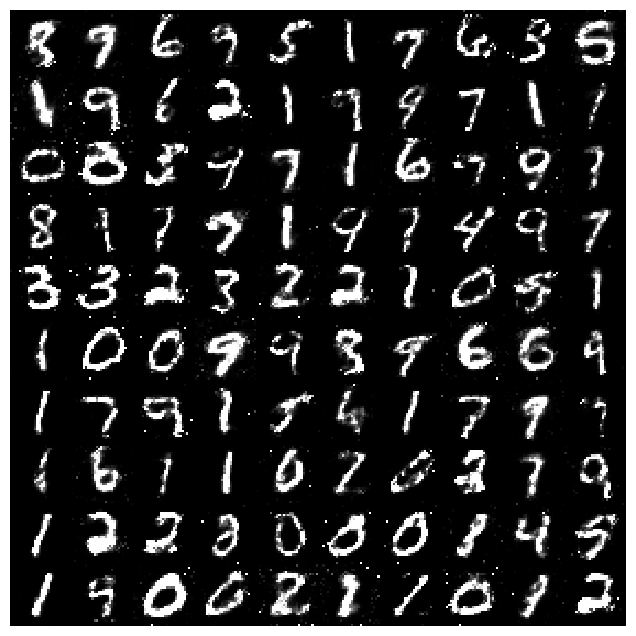

Epoch:   63
D Loss:  0.5882894992828369
G Loss:  0.8379988670349121
Epoch:   64
D Loss:  0.5823979377746582
G Loss:  0.8935750722885132


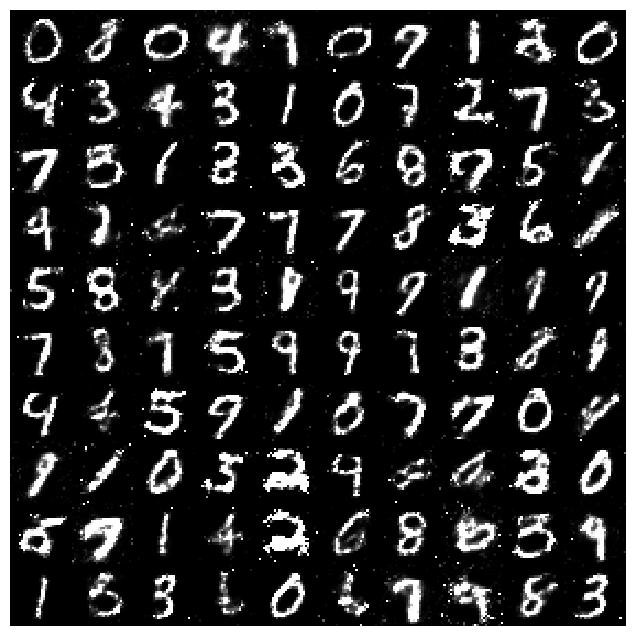

Epoch:   65
D Loss:  0.6050865650177002
G Loss:  1.0717966556549072
Epoch:   66
D Loss:  0.5846003293991089
G Loss:  0.8173395991325378


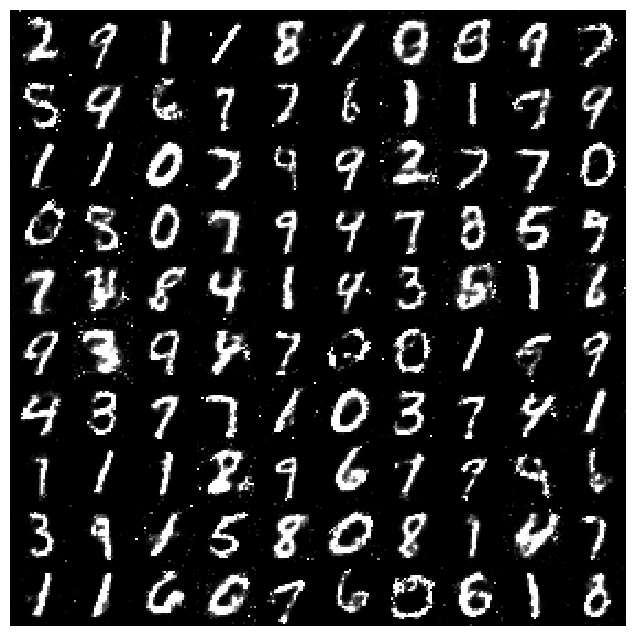

Epoch:   67
D Loss:  0.5529041886329651
G Loss:  0.8831695318222046
Epoch:   68
D Loss:  0.5701050758361816
G Loss:  0.8671094179153442


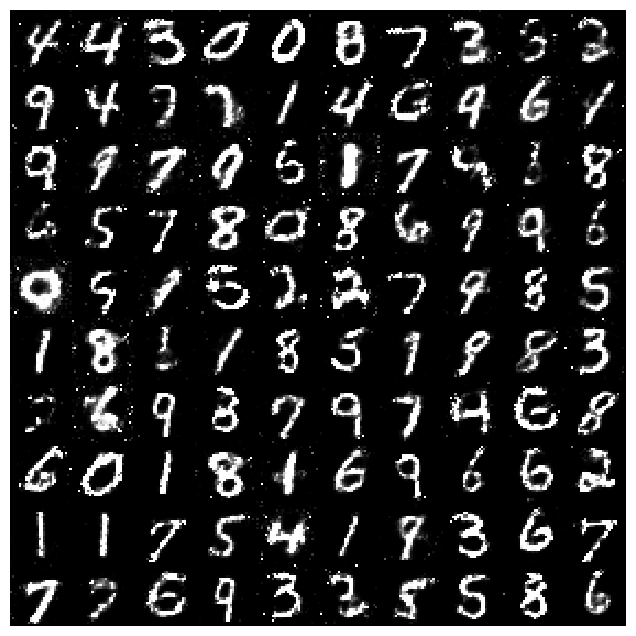

Epoch:   69
D Loss:  0.7095154523849487
G Loss:  1.267248272895813
Epoch:   70
D Loss:  0.5748245716094971
G Loss:  0.8361138701438904


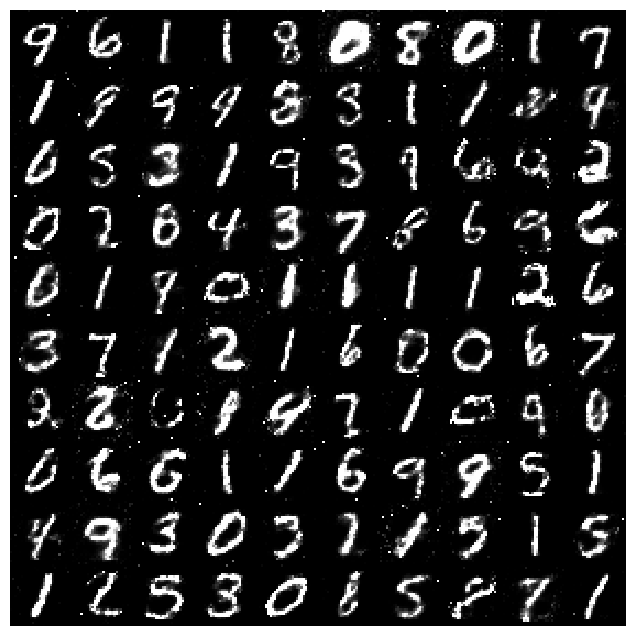

Epoch:   71
D Loss:  0.5879741907119751
G Loss:  1.002939224243164
Epoch:   72
D Loss:  0.5645723342895508
G Loss:  0.8959562182426453


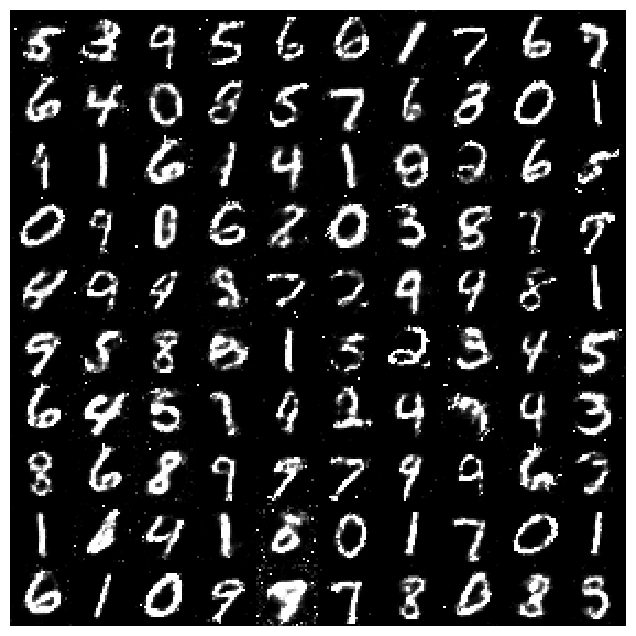

Epoch:   73
D Loss:  0.5615029335021973
G Loss:  0.9513987302780151
Epoch:   74
D Loss:  0.5900232791900635
G Loss:  0.7528490424156189


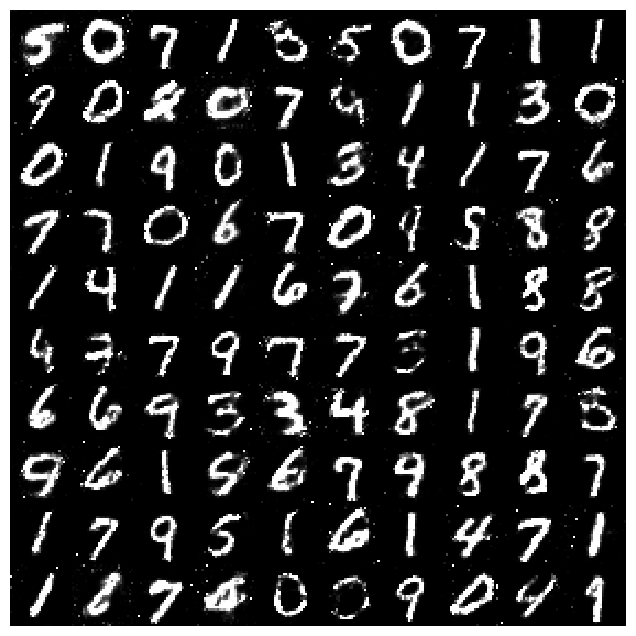

Epoch:   75
D Loss:  0.5851941704750061
G Loss:  0.955979585647583
Epoch:   76
D Loss:  0.5930278301239014
G Loss:  0.7801343202590942


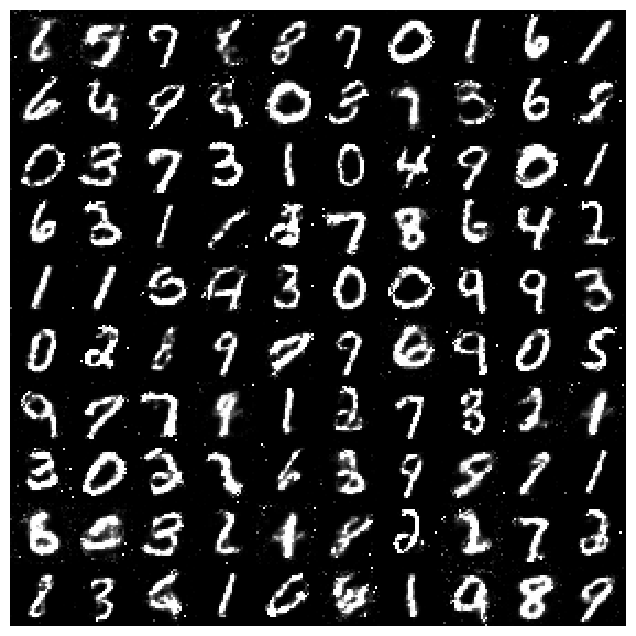

Epoch:   77
D Loss:  0.5869976878166199
G Loss:  0.850702702999115
Epoch:   78
D Loss:  0.5734959840774536
G Loss:  0.9305598735809326


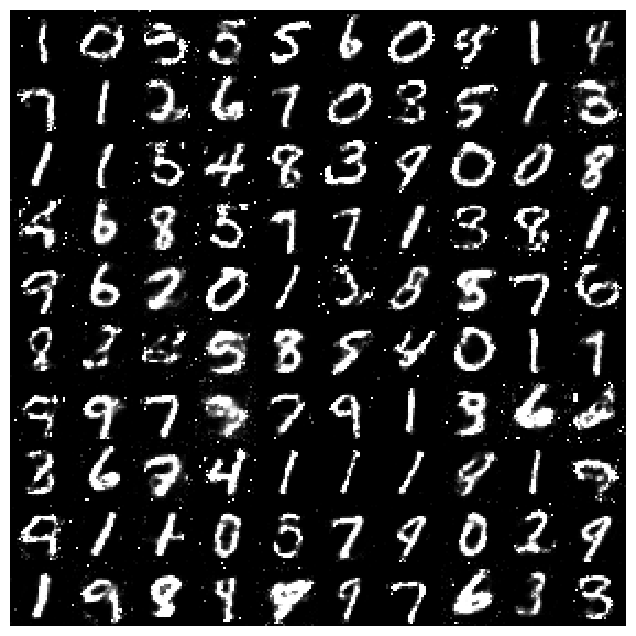

Epoch:   79
D Loss:  0.5494542717933655
G Loss:  0.8455575704574585


In [62]:
## Training loop

for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        
        
        
        targets_real = (torch.FloatTensor(images.size(0), 1).uniform_(0.8, 1.0))
        targets_fake = (torch.FloatTensor(images.size(0), 1).uniform_(0.0, 0.2))
                
        if is_cuda:
            targets_real = targets_real.cuda()
            targets_fake = targets_fake.cuda()
            images = images.cuda()
        
        
        ## D-STEP:
        ## First, clear the gradients of the Discriminator optimizer.
        optimizer_D.zero_grad()
        ## Estimate logits_real by passing images through the Discriminator
        logits_real = discriminator(images)
        ## Generate fake_images by passing random noise through the Generator. Also, .detach() the fake images 
        ## as we don't compute the gradients of the Generator when optimizing Discriminator.
        fake_images = generator(noise(train_bs, noise_dim)).detach()
        ## Estimate logits_fake by passing the fake images through the Discriminator
        logits_fake = discriminator(fake_images)
        ## Compute the Discriminator loss by calling DLoss function.
        discriminator_loss = DLoss(logits_real, logits_fake, targets_real, targets_fake)
        ## Compute the gradients by backpropagating through the computational graph. 
        discriminator_loss.backward()
        ## Update the Discriminator parameters.
        optimizer_D.step()
        
        ## G-STEP:
        ## clear the gradients of the Generator. 
        optimizer_G.zero_grad()
        ## Generate fake images by passing random noise through the Generator. 
        fake_images = generator(noise(train_bs, noise_dim))
        ## Estimate logits_fake by passing the fake images through the Discriminator.
        logits_fake = discriminator(fake_images)
        ## compute the Generator loss by caling GLoss.
        generator_loss = GLoss(logits_fake, targets_real)
        ## compute the gradients by backpropagating through the computational graph.
        generator_loss.backward()
        ## Update the Generator parameters. 
        optimizer_G.step()
        
    print("Epoch:  ", epoch)
    print("D Loss: ", discriminator_loss.item())
    print("G Loss: ", generator_loss.item())
          
    if epoch % 2 == 0:
        viz_batch = fake_images.data.cpu().numpy()
        viz_batch = viz_batch[:100,:,:,:]
        viz_batch = viz_batch.reshape(-1,28*28).squeeze()
        viz_batch = viz_batch.reshape(10,10, 28,28).transpose(0,2,1,3).reshape(28*10,-1)

        plt.figure(figsize = (8,8))
        plt.axis('off')
        plt.imshow(viz_batch, cmap='gray')
        plt.show()